In [1]:
import os
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow as tf
import tensorflow.contrib.slim as slim
import time
style.use('fivethirtyeight')

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Create the gym environment.
env = gym.make('CartPole-v0')

<IPython.core.display.Javascript object>


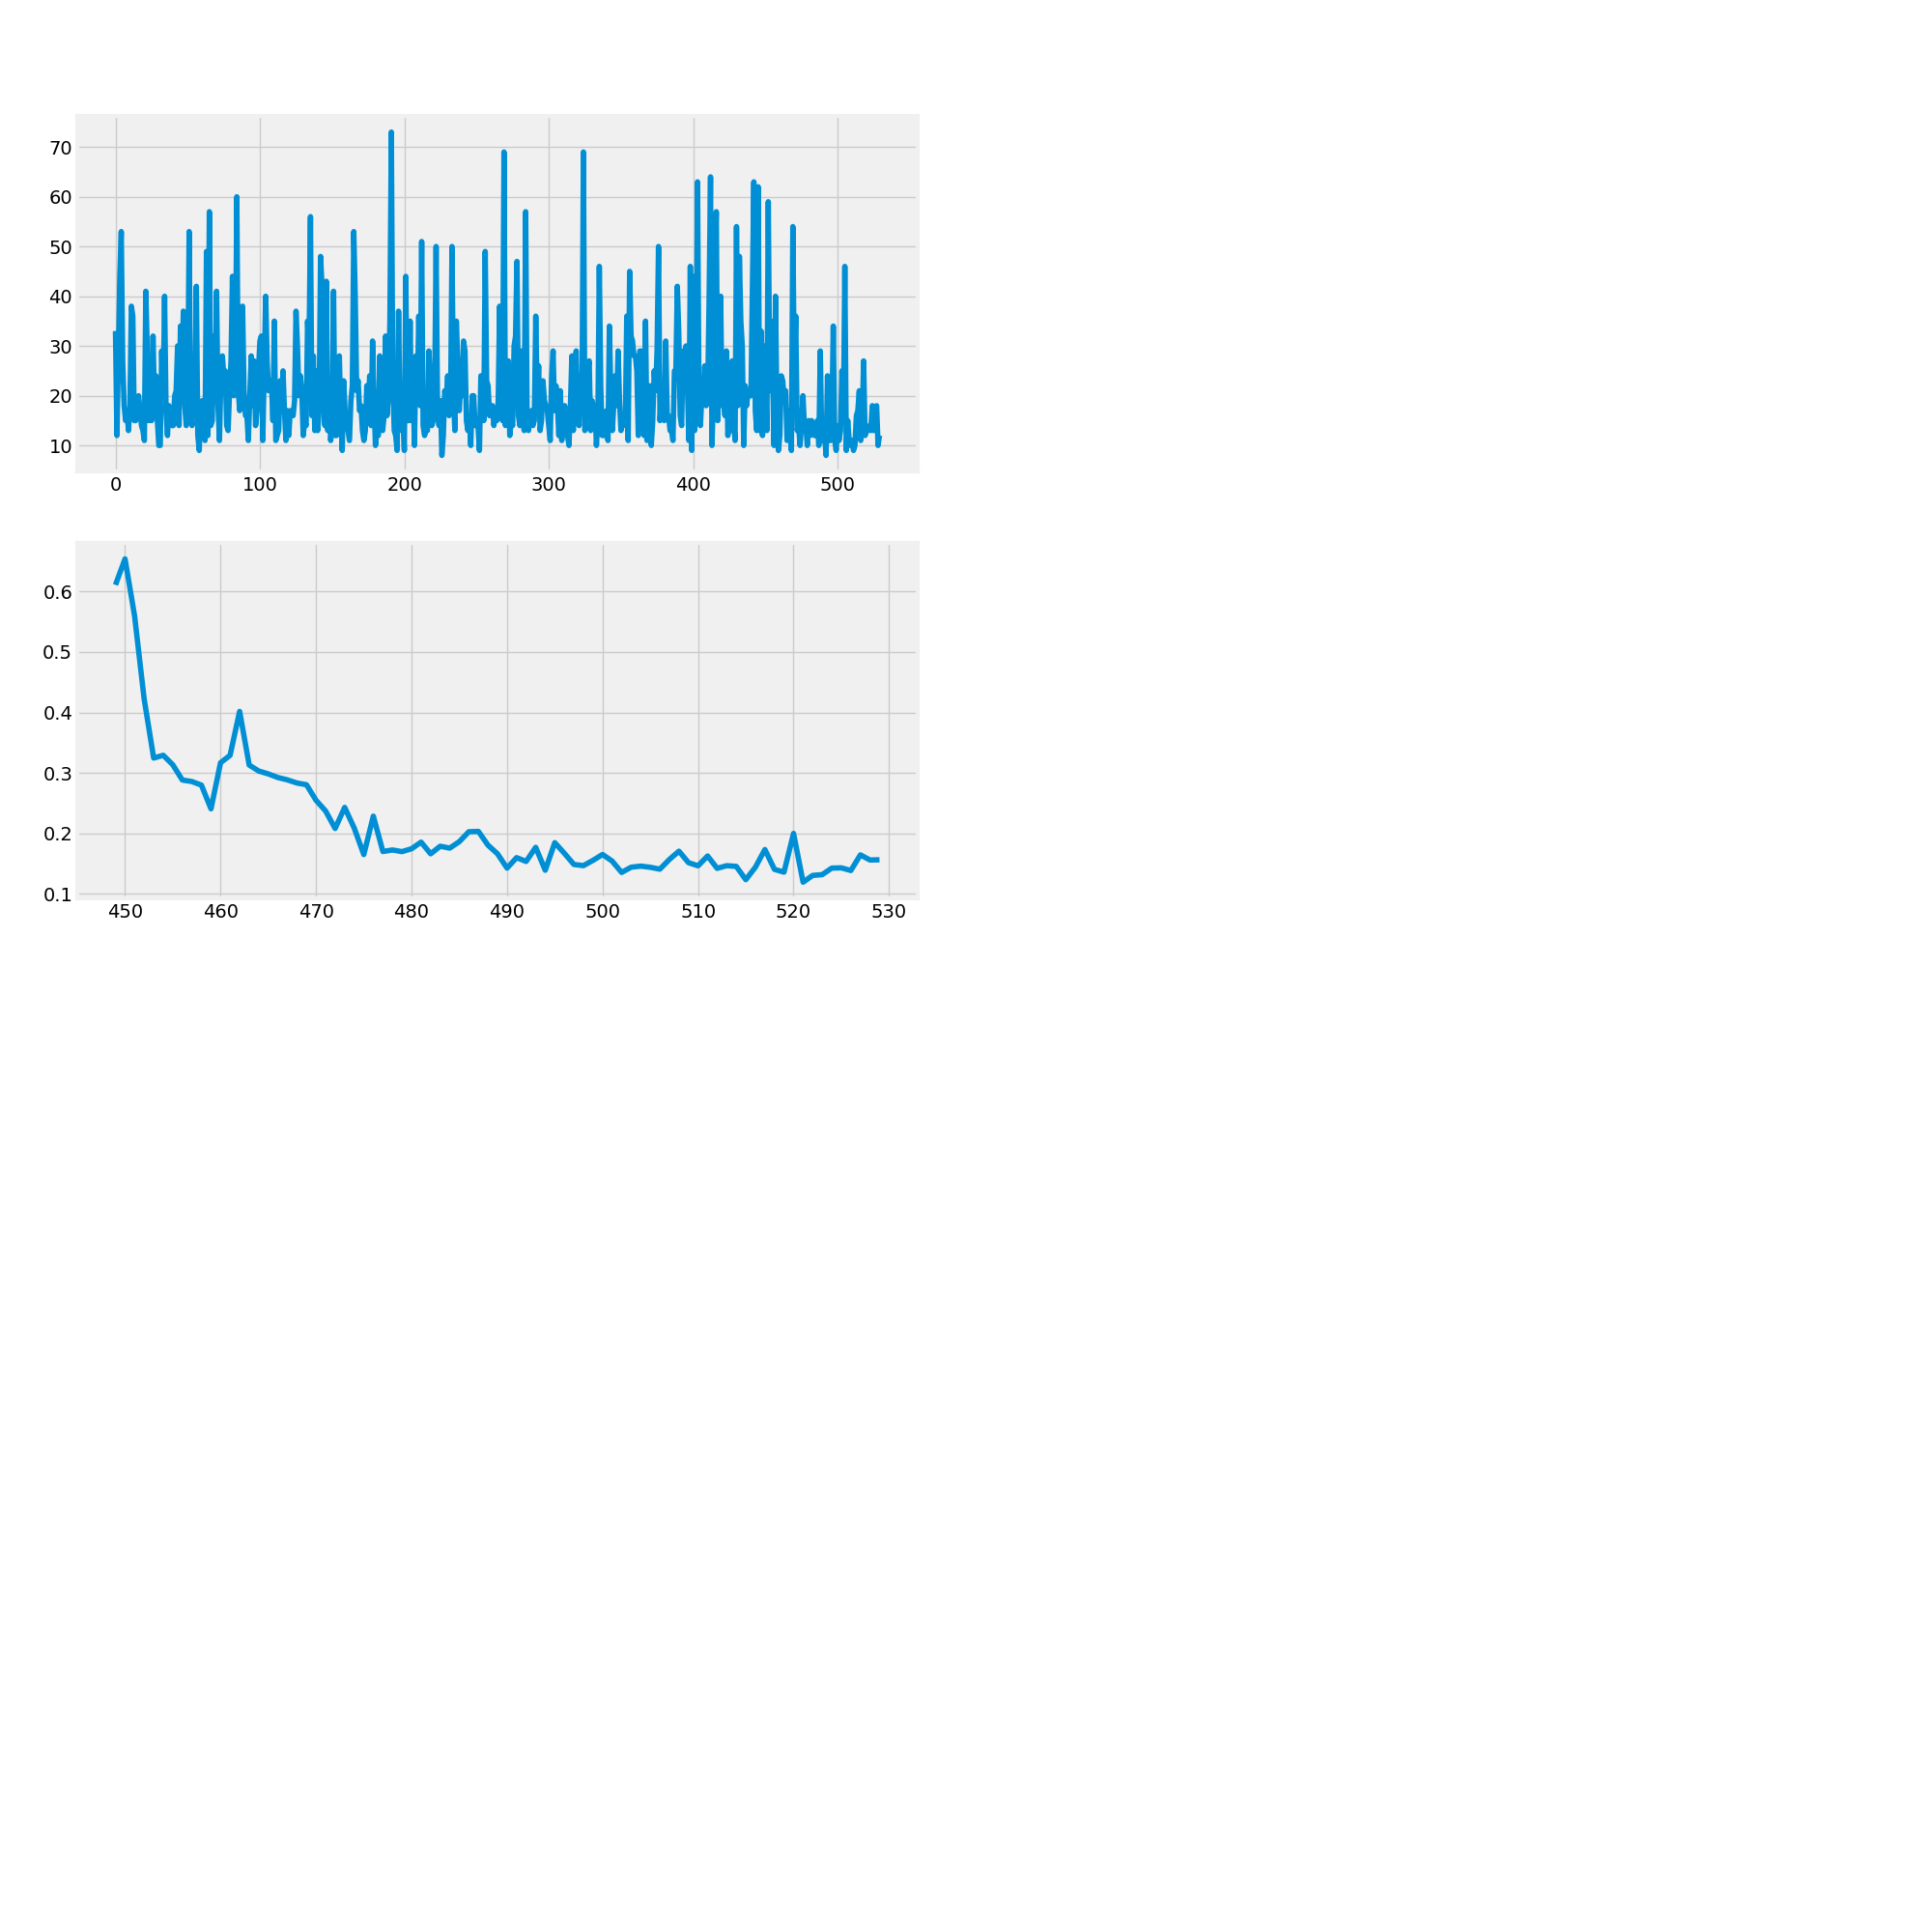

In [3]:
%matplotlib notebook
m = 100
n = 100
matrix = np.random.normal(0,1,m*n).reshape(m,n)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Episode count')
ax1.set_ylabel('Reward')
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Episode count')
ax2.set_ylabel('Loss')
plt.ion()

fig.show()
fig.canvas.draw()
def refresh_chart(rewards, mean_loss):
    ax1.clear()
    ax2.clear()
    ax1.plot(rewards)
    ax2.plot(mean_loss)
    fig.canvas.draw()

### Helper functions

Helper functions to update the target Q-Network toward the primary Q-network at a rate $\tau$.

In [4]:
# Get the update operations to perform.
def target_network_update_ops(tvars, tau):
    op_holder = []
    num_variables = len(tvars)
    for ix, var in enumerate(tvars[0:num_variables//2]):
        # The trainable variables for the target network is
        # in the second half of the list of tvars.
        updated_value = tvars[ix + num_variables//2].value() * (1 - tau) + var.value() * tau
        op_holder.append(tvars[ix + num_variables//2].assign(updated_value))
    return op_holder

# Apply the update operations on the target network.
def target_network_update_apply(sess, ops):
    for op in ops:
        sess.run(op)

In [5]:
# Helper function to compute the Huber loss with delta = 1.
def huber_loss(diff):
    diff = tf.abs(diff)
    return tf.where(tf.less(diff, 1), tf.square(diff), diff - 0.5)

### Experience replay

In [6]:
class Cache():
    def __init__(self, max_size=50000):
        self.buffer = []
        self.max_size = max_size
    
    def add(self, data):
        if len(self.buffer)+ len(data) > self.max_size:
            # Evict the oldest experiences if not enough space.
            ix = len(self.buffer) + len(data) - self.max_size
            self.buffer[0:ix] = [] 
        self.buffer.extend(data)

class ExperienceReplayBuffer(Cache):
    def __init__(self, max_size=50000):
        Cache.__init__(self, max_size)
    
    def sample_batch(self, batch_size):
        return np.reshape(np.array(random.sample(self.buffer, batch_size)), [batch_size, 5])

### Q-network

In [7]:
class QNetwork():
    def __init__(self, lr, s_size, a_size, h_size, o_size, name):
        if o_size % 2 != 0:
            raise ValueError('Number of outputs from final layer must be even')
            
        # Forward pass of the network.
        # output: batch_size x s_size
        self.state_input = tf.placeholder(shape=[None, s_size], dtype=tf.float32)
        
        xavier_init = tf.contrib.layers.xavier_initializer()
        # output: batch_size x h_size
        layer1 = self.relu_batch_norm_layer(self.state_input, h_size, name +"-layer1")
        # Layer 2.
        layer2 = self.relu_batch_norm_layer(layer1, h_size, name +"-layer2")
        # output: batch_size x o_size
        self.fully_connected_output = self.relu_batch_norm_layer(layer2, o_size, name +"-layer3")
        
        # Average Dueling
        # output(each): batch_size x o_size/2
        self.V_stream, self.A_stream = tf.split(self.fully_connected_output, num_or_size_splits=2, axis=1)
        self.V_weights = tf.Variable(xavier_init([o_size//2, 1]))
        self.A_weights = tf.Variable(xavier_init([o_size//2, a_size]))
        
        # output: batch_size x 1
        self.state_value = tf.matmul(self.V_stream, self.V_weights)
        # output: batch_size x a_size
        self.advantage = tf.matmul(self.A_stream, self.A_weights)
        
        self.Qout = self.state_value + tf.subtract(self.advantage, 
                                                   tf.reduce_mean(self.advantage, axis=1, keep_dims=True))
        # Predict action that maximizes Q-value.
        self.action_predicted = tf.argmax(self.Qout, axis=1)
        
        # Evaluate loss and backward pass.
        self.target_Q = tf.placeholder(shape=[None], dtype=tf.float32)             
        self.actions_taken = tf.placeholder(shape=[None], dtype=tf.int32)       
        self.action_taken_one_hot = tf.one_hot(self.actions_taken, a_size, dtype=tf.float32)
        self.predicted_Q = tf.reduce_sum(tf.multiply(self.Qout, self.action_taken_one_hot), axis=1)
        
        self.prediction_loss = tf.reduce_mean(huber_loss(self.predicted_Q - self.target_Q))
        
        # Optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = self.optimizer.minimize(self.prediction_loss)
    
    def relu_batch_norm_layer(self, x, out_size, scope):
        xavier_init = tf.contrib.layers.xavier_initializer()
        return slim.fully_connected(x, out_size,
                                   normalizer_fn=slim.batch_norm,
                                   weights_initializer=xavier_init,
                                   activation_fn=tf.nn.relu,
                                   scope=scope)

### Training

In [8]:
batch_size = 100
update_frequency = 5 # Update every 5 steps.
gamma = 0.9 # Discount factor.
epsilon_decay_rate = 0.9
epsilon_min = 0.01
total_episodes = 10000
max_ep_length = 300
pretrain_steps = 10000
load_model = False
render_env = False
path = './model'

h_size = 200
o_size = 200
a_size = env.action_space.n 
s_size = env.observation_space.shape[0]

tau = 0.01
learning_rate = 0.0001
save_model_episode_interval = 5
epsilon_update_interval = 4

In [9]:
tf.reset_default_graph()
primary_Q_network = QNetwork(learning_rate, s_size, a_size, h_size, o_size, "primary")
target_Q_network = QNetwork(learning_rate, s_size, a_size, h_size, o_size, "target")

init = tf.global_variables_initializer()
saver = tf.train.Saver(save_relative_paths=True)
tvars = tf.trainable_variables()
target_network_update_operations = target_network_update_ops(tvars, tau)

experience_buffer = ExperienceReplayBuffer()
all_rewards = []
steps_taken = []
all_losses = []

epsilon = 1.0
fig.show()
fig.canvas.draw()

# Create folder to store model in, if doesn't exist.
if not os.path.exists(path):
    os.makedirs(path)

total_step_count = 0
with tf.Session() as sess:
    sess.run(init)    
    if load_model:
        print('Loading latest saved model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for episode_count in range(1, total_episodes + 1):
        step_count = 0
        episode_buffer = []
        running_reward = 0
        episode_loss = []
        done = False
        
        s = env.reset()
        while step_count < max_ep_length and not done:
            env.render()
            step_count += 1
            total_step_count += 1
            if np.random.randn(1) < epsilon or total_step_count < pretrain_steps:
                action = np.random.randint(0, a_size)
            else:
                action = sess.run(primary_Q_network.action_predicted, 
                                 feed_dict={primary_Q_network.state_input:[s]})[0]
                if total_step_count % 10 == 0:
                    print('Action: '+ str(action))
            
            next_state, reward, done, _ = env.step(action)
            d_int = 1 if done else 0
            running_reward += reward
            episode_buffer.append([s, action, reward, next_state, d_int])
            s = next_state
            
            if total_step_count > pretrain_steps:
                if total_step_count % update_frequency == 0:
                    train_batch = experience_buffer.sample_batch(batch_size)
                    # Double DQN
                    max_next_state_action =  sess.run(primary_Q_network.action_predicted,
                             feed_dict={ primary_Q_network.state_input:np.vstack(train_batch[:,3])}) 
                    target_network_Q_values = sess.run(target_Q_network.Qout,feed_dict={
                        target_Q_network.state_input:np.vstack(train_batch[:,3])})  
                    
                    Q_values_next_state = target_network_Q_values[range(batch_size),max_next_state_action]
                    end_multiplier = (1 - train_batch[:,4])
                    target_Q_values = train_batch[:,2] +(gamma * Q_values_next_state * end_multiplier)
                    # Update the primary network.
                    l, _ = sess.run([primary_Q_network.prediction_loss, primary_Q_network.update], feed_dict={
                        primary_Q_network.state_input: np.vstack(train_batch[:,0]),
                        primary_Q_network.actions_taken: train_batch[:,1],
                        primary_Q_network.target_Q: target_Q_values
                    })
                    episode_loss.append(np.mean(l))
                    # Update the target network.
                    target_network_update_apply(sess, target_network_update_operations)

        
        experience_buffer.add(episode_buffer)
        all_rewards.append(running_reward)
        all_losses.append(np.mean(episode_loss))
        steps_taken.append(step_count)
        # Save model periodically.
        if total_step_count > pretrain_steps and episode_count % epsilon_update_interval == 0:
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay_rate
        if total_step_count > pretrain_steps and episode_count % save_model_episode_interval == 0:
            print('Saving model...')
            saver.save(sess, path+'/model-'+str(episode_count)+'.ckpt', global_step=total_step_count)
            refresh_chart(all_rewards, all_losses)

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Action: 0
Saving model...
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Saving model...
Action: 1
Action: 1
Action: 1
Saving model...


KeyboardInterrupt: 